In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.callbacks import *
sys.path.append('..')
from audio import *

In [3]:
#To have reproducible results with fastai you must also set num_workers=1 in your databunch, and seed=seed
#in split_by_rand_pct
seed = 42
# python RNG
random.seed(seed)
# pytorch RNGs
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
# numpy RNG
np.random.seed(seed)

## Introduction

In this notebook we will be continuing with the Google Tensorflow Speech Challenge on Kaggle, using fastai audio to implement a 2nd model, this one based on melspectrograms. For augmentation we will use SpecAugment and we will increase the size of the images. We won't use mixup as I haven't had as much luck with it on speech data. For architecture we will use either a resnet18 or resnet34. We can then combine this with our MFCC based models and pseudolabel our testset to fine-tune them both, before making our final predictions.

Warning: We have some indication that resnets aren't optimal for audio, but we haven't yet experimented with audio specific options. That being said we still get really great results, so it should be good for most purposes.

In [4]:
PATH_BASE = Path('../data/google_speech/')
PATH_TEST = PATH_BASE/'test/audio/'
PATH_DATA = PATH_BASE/'train/audio/'

Our setup is pretty simple, we set "duration" to 1008 because it gives us 128x128 which we will then upsample to 256x256 and apply specaugment. We will start with full data and train, but feel free to set partial data to .05 or lower and experiment with various configurations and transforms. 

In [5]:
sg_cfg= SpectrogramConfig(hop=126, n_mels=128, n_fft=1028, f_max=8000, top_db=80, f_min=20)
cfg = AudioConfig(cache=True, duration=1008, sg_cfg=sg_cfg)
sg_cfg

SpectrogramConfig(f_min=20, f_max=8000, hop=126, n_fft=1028, n_mels=128, pad=0, to_db_scale=True, top_db=80, ws=None, n_mfcc=20)

In [52]:
data_pct = 1

In [55]:
al_train = (AudioList.from_folder(PATH_DATA, config=cfg)
            .use_partial_data(data_pct)
            .filter_by_folder(exclude='_background_noise_')
            .split_by_rand_pct(0.1, seed=seed)
            .label_from_folder())

In [9]:
al_train.train[0][0].shape

torch.Size([3, 128, 128])

Remember that when using SpecAugment, you can do math to sanity check your bars and see if they are reasonable. Our image size is 224x224, our clips are 1s long, so say we want to hide 0.1s of info from each sg, we can set num_cols = 224/10 = 22. Since most utterances are more like 0.4s, this seems like plenty.

In [56]:
tfms = get_spectro_transforms(size=(224,224), roll=False, num_rows=40, num_cols=22)
#tfms = get_spectro_transforms(roll=False, fmasks=2, num_rows=32, num_cols=24)

In [57]:
tfms

([functools.partial(<function tfm_interpolate at 0x7f8690051158>, size=(224, 224), num_rows=40, num_cols=22),
  functools.partial(<function tfm_mask_time at 0x7f8690051268>, num_rows=40, num_cols=22),
  functools.partial(<function tfm_mask_frequency at 0x7f86900512f0>, num_rows=40, num_cols=22)],
 [functools.partial(<function tfm_interpolate at 0x7f8690051158>, size=(224, 224), num_rows=40, num_cols=22)])

In [58]:
db_audio = al_train.transform(tfms).databunch(bs=128)

------------------------------------------------------------
File: ../data/google_speech/train/audio/unknown/tree-571c044e_nohash_1.wav
Total Length: 1.0 seconds
Label: unknown


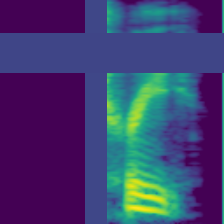

Shape: 224x224
------------------------------------------------------------
File: ../data/google_speech/train/audio/unknown/zero-6f2f57c1_nohash_0.wav
Total Length: 1.0 seconds
Label: unknown


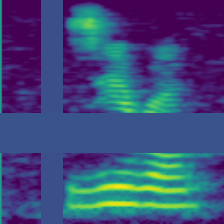

Shape: 224x224
------------------------------------------------------------
File: ../data/google_speech/train/audio/unknown/wow-30802c5d_nohash_1.wav
Total Length: 1.0 seconds
Label: unknown


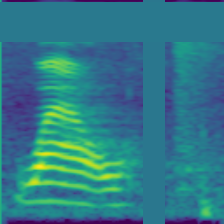

Shape: 224x224


In [59]:
db_audio.show_batch()

In [20]:
learn = audio_learner(db_audio, models.resnet18, metrics=accuracy,callback_fns=[ShowGraph, CSVLogger], pretrained=False)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


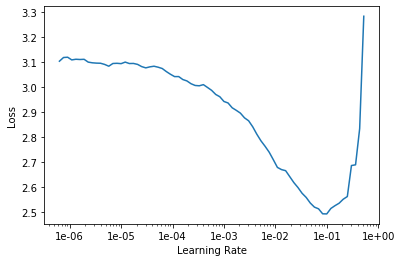

In [29]:
learn.lr_find()
learn.recorder.plot()

One note here is that in the SpecAugment paper, they mention their best results come from a relatively low learning rate (1e-3) and a lot of epochs. We don't do that here for times sake since I don't want to train for hours, but it very well might lead to a better result.

epoch,train_loss,valid_loss,accuracy,time
0,0.906893,0.572328,0.807420,03:47
1,0.378626,0.279394,0.919022,03:46
2,0.277193,0.178290,0.946996,03:47
3,0.220115,0.114350,0.967609,03:47
4,0.171048,0.114086,0.966578,03:47
5,0.133692,0.071494,0.980271,03:47
6,0.113017,0.061955,0.984541,03:47
7,0.076850,0.061227,0.983804,03:47
8,0.067674,0.056295,0.986160,03:47
9,0.062667,0.054103,0.986896,03:47


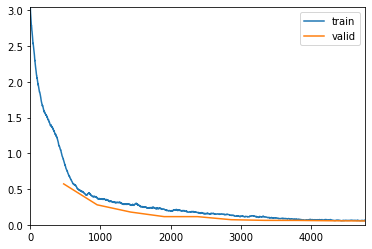

Better model found at epoch 0 with accuracy value: 0.8074204921722412.
Better model found at epoch 1 with accuracy value: 0.9190223813056946.
Better model found at epoch 2 with accuracy value: 0.9469964504241943.
Better model found at epoch 3 with accuracy value: 0.9676089286804199.
Better model found at epoch 5 with accuracy value: 0.9802709221839905.
Better model found at epoch 6 with accuracy value: 0.9845406413078308.
Better model found at epoch 8 with accuracy value: 0.986160159111023.
Better model found at epoch 9 with accuracy value: 0.9868963360786438.


In [21]:
learn.fit_one_cycle(10, max_lr=slice(7e-3),callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy')])

98.69% accuracy, already better than our MFCC! Let's check out how we're doing before fitting a bit more

In [22]:
interp = ClassificationInterpretation.from_learner(learn)

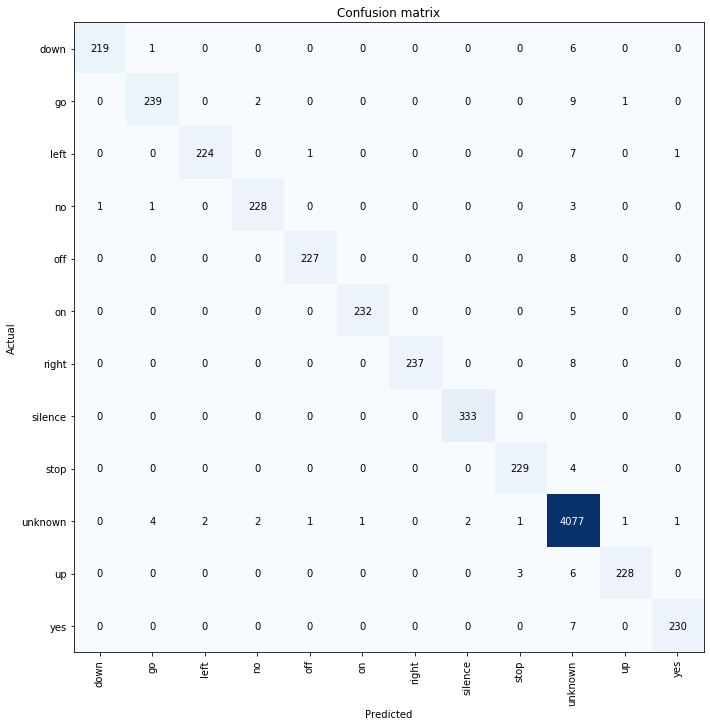

In [23]:
interp.plot_confusion_matrix(figsize=(10,10))

All most confused still involve overpredicting unknown but this is to be expected as it is about 60% of our samples. We could do more analysis here by calculating pct accuracy for each class, but I won't go down that road here.

In [26]:
interp.most_confused(5)

[('go', 'unknown', 9),
 ('off', 'unknown', 8),
 ('right', 'unknown', 8),
 ('left', 'unknown', 7),
 ('yes', 'unknown', 7),
 ('down', 'unknown', 6),
 ('up', 'unknown', 6),
 ('on', 'unknown', 5)]

File: ../data/google_speech/train/audio/up/d90b4138_nohash_0.wav
Total Length: 1.0 seconds
Label: unknown/up / 17.98 / 0.00


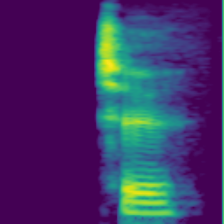

Shape: 224x224
File: ../data/google_speech/train/audio/right/190821dc_nohash_3.wav
Total Length: 1.0 seconds
Label: unknown/right / 14.06 / 0.00


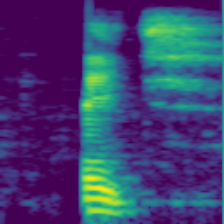

Shape: 224x224
File: ../data/google_speech/train/audio/unknown/bird-3e7124ba_nohash_0.wav
Total Length: 1.0 seconds
Label: silence/unknown / 13.56 / 0.00


/opt/anaconda3/lib/python3.7/site-packages/IPython/lib/display.py:136: RuntimeWarning: invalid value encountered in true_divide
  scaled = np.int16(data/np.max(np.abs(data))*32767).tolist()


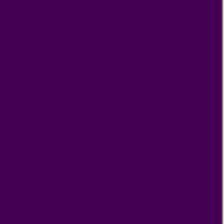

Shape: 224x224
File: ../data/google_speech/train/audio/go/190821dc_nohash_2.wav
Total Length: 1.0 seconds
Label: unknown/go / 9.70 / 0.00


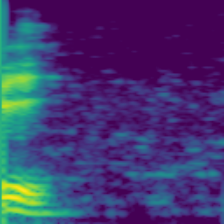

Shape: 224x224
File: ../data/google_speech/train/audio/on/8012c69d_nohash_3.wav
Total Length: 1.0 seconds
Label: unknown/on / 9.41 / 0.00


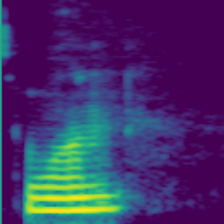

Shape: 224x224
File: ../data/google_speech/train/audio/unknown/nine-8eb4a1bf_nohash_1.wav
Total Length: 1.0 seconds
Label: go/unknown / 8.92 / 0.00


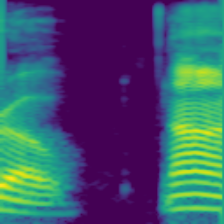

Shape: 224x224
File: ../data/google_speech/train/audio/unknown/zero-d90b4138_nohash_2.wav
Total Length: 1.0 seconds
Label: silence/unknown / 8.81 / 0.00


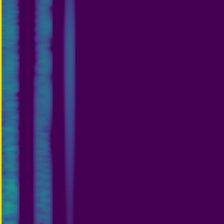

Shape: 224x224
File: ../data/google_speech/train/audio/right/f8f60f59_nohash_0.wav
Total Length: 1.0 seconds
Label: unknown/right / 8.45 / 0.00


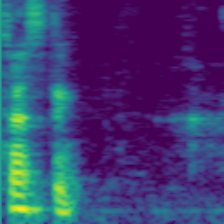

Shape: 224x224
File: ../data/google_speech/train/audio/down/712e4d58_nohash_1.wav
Total Length: 1.0 seconds
Label: unknown/down / 7.81 / 0.00


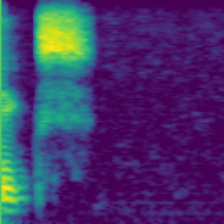

Shape: 224x224


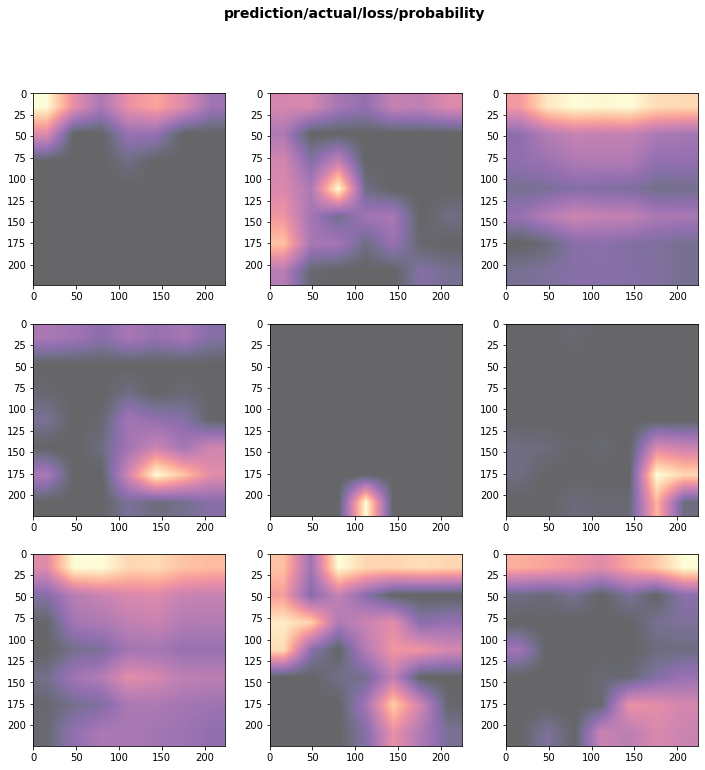

In [27]:
interp.plot_top_losses(9)

Wow, upon closer inspection it seems like our model is labeling the data more accurately than the competition's labels. Almost every prediction above is correct, and it's actually the label that is wrong. Even in the second case which is really subtle, it sounds to me like he is saying eight or ight, and not right, and our model labeled this as 'unknown' instead of right. Pretty cool. Also notice that we got the pure silence wrong, which is weird, but we can maybe copy 100 more of those into the silence folder and hope it helps. We won't reload the data now after adding it because I'm worried it will mess up our validation, but it should help later when we fine tune on pseudolabeled data. 

In [29]:
for i in range(250):
    savepath = str(PATH_DATA/f'silence/pure_silence_{i}.wav')
    sig = torch.zeros(16000)
    torchaudio.save(savepath, sig, 16000)
display(Audio(str(PATH_DATA/f'silence/pure_silence_132.wav')))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


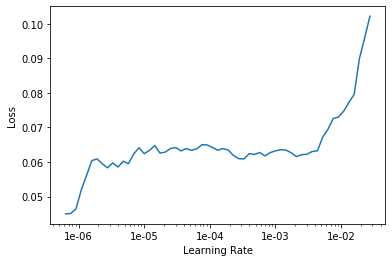

In [30]:
learn.lr_find()
learn.recorder.plot()

In [31]:
learn.save('mel-stage1')

In [32]:
learn.export('/home/jupyter/google-mel-stg1.pkl')

epoch,train_loss,valid_loss,accuracy,time
0,0.066378,0.062271,0.984835,03:43
1,0.100339,0.071117,0.982332,03:47
2,0.107201,0.062144,0.983068,03:47
3,0.114408,0.076805,0.982038,03:47
4,0.091878,0.072385,0.981302,03:47
5,0.081578,0.063422,0.983804,03:47
6,0.058100,0.060204,0.985866,03:47
7,0.046041,0.054576,0.988221,03:47
8,0.046645,0.054926,0.987191,03:47
9,0.040059,0.053863,0.987485,03:47


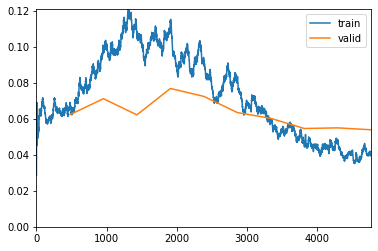

Better model found at epoch 0 with accuracy value: 0.9848350882530212.
Better model found at epoch 6 with accuracy value: 0.9858657121658325.
Better model found at epoch 7 with accuracy value: 0.9882214665412903.


In [33]:
learn.fit_one_cycle(10, max_lr=slice(4e-4, 1.4e-3),callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy')])

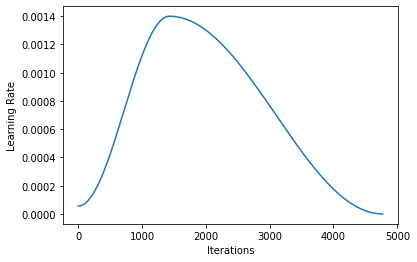

In [37]:
learn.recorder.plot_lr()


In [38]:
learn.save('mel-stage2')

In [46]:
learn.load('mel-stage2')

Learner(data=AudioDataBunch;

Train: AudioLabelList (61131 items)
x: AudioList
AudioItem 1.0 seconds (16000 samples @ 16000hz),AudioItem 1.0 seconds (16000 samples @ 16000hz),AudioItem 1.0 seconds (16000 samples @ 16000hz),AudioItem 0.93 seconds (14861 samples @ 16000hz),AudioItem 1.0 seconds (16000 samples @ 16000hz)
y: CategoryList
silence,right,left,unknown,unknown
Path: ../data/google_speech/train/audio;

Valid: AudioLabelList (6792 items)
x: AudioList
AudioItem 1.0 seconds (16000 samples @ 16000hz),AudioItem 1.0 seconds (16000 samples @ 16000hz),AudioItem 1.0 seconds (16000 samples @ 16000hz),AudioItem 1.0 seconds (16000 samples @ 16000hz),AudioItem 1.0 seconds (16000 samples @ 16000hz)
y: CategoryList
unknown,unknown,unknown,unknown,unknown
Path: ../data/google_speech/train/audio;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [48]:
learn.export('/home/jupyter/google-mel-stg2.pkl')

## Inference

In [6]:
sg_cfg= SpectrogramConfig(hop=126, n_mels=128, n_fft=1028, f_max=8000, top_db=80, f_min=20)
cfg = AudioConfig(cache=True, duration=1008, sg_cfg=sg_cfg)

In [64]:
test = AudioList.from_folder(PATH_TEST, config=cfg); test

AudioList (158538 items)
AudioItem 1.0 seconds (16000 samples @ 16000hz),AudioItem 1.0 seconds (16000 samples @ 16000hz),AudioItem 1.0 seconds (16000 samples @ 16000hz),AudioItem 1.0 seconds (16000 samples @ 16000hz),AudioItem 1.0 seconds (16000 samples @ 16000hz)
Path: ../data/google_speech/test/audio

In [65]:
learn = load_learner('/home/jupyter/', 'google-mel-stg2.pkl', test=test)

File: ../data/google_speech/test/audio/clip_773b7caf8.wav
Total Length: 1.0 seconds


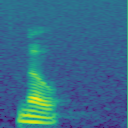

Shape: 128x128
torch.Size([1, 224, 224])


In [77]:
item = test[3]
item.show()
x, _, _, _ = learn.predict(item, return_x=True)
Image(x[0].unsqueeze(0))
print(x[0].unsqueeze(0).shape)

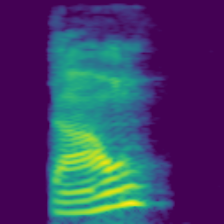

In [48]:
Image(x[0].unsqueeze(0))


In [61]:
learn.data = db_audio
learn.validate()

[0.017489588, tensor(0.9949)]

In [8]:
Audio(str(PATH_TEST/'clip_b1997f379.wav'))

In [23]:
preds, y = learn.get_preds(ds_type=DatasetType.Test)

In [24]:
with open('mel_preds.pkl', 'wb') as f:
    pickle.dump(preds, f)

In [27]:
with open('mel_preds.pkl', 'rb') as f:
    preds_list = pickle.load(f)

In [10]:
len(preds_list)

158538

In [86]:
confidence_list = []
print(learn.data.classes)
for idx, item in enumerate(test.items):
    if(idx % 1000 == 0): print(idx)
    confidence = torch.max(preds_list[idx]).item()
    label = learn.data.classes[torch.argmax(preds_list[idx])]
    confidence_list.append((item, label, confidence))

['down', 'go', 'left', 'no', 'off', 'on', 'right', 'silence', 'stop', 'unknown', 'up', 'yes']
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
1450

In [93]:
for item, label, conf in confidence_list[158150:158200]:
    AudioItem(path=item).hear()
    print(label)
    print(conf)
    print('-'*100)

unknown
0.9999958276748657
----------------------------------------------------------------------------------------------------


silence
0.9784604907035828
----------------------------------------------------------------------------------------------------


unknown
0.999539852142334
----------------------------------------------------------------------------------------------------


/opt/anaconda3/lib/python3.7/site-packages/IPython/lib/display.py:136: RuntimeWarning: invalid value encountered in true_divide
  scaled = np.int16(data/np.max(np.abs(data))*32767).tolist()


silence
1.0
----------------------------------------------------------------------------------------------------


on
0.802463710308075
----------------------------------------------------------------------------------------------------


unknown
0.6026518940925598
----------------------------------------------------------------------------------------------------


yes
0.9998235106468201
----------------------------------------------------------------------------------------------------


unknown
0.8775618076324463
----------------------------------------------------------------------------------------------------


stop
0.828416645526886
----------------------------------------------------------------------------------------------------


unknown
0.8106511235237122
----------------------------------------------------------------------------------------------------


unknown
0.5601444840431213
----------------------------------------------------------------------------------------------------


unknown
0.6687963008880615
----------------------------------------------------------------------------------------------------


no
0.9599870443344116
----------------------------------------------------------------------------------------------------


no
0.6052080988883972
----------------------------------------------------------------------------------------------------


unknown
0.9988975524902344
----------------------------------------------------------------------------------------------------


off
0.9005756974220276
----------------------------------------------------------------------------------------------------


down
0.9360330104827881
----------------------------------------------------------------------------------------------------


unknown
0.6085105538368225
----------------------------------------------------------------------------------------------------


unknown
0.9174646735191345
----------------------------------------------------------------------------------------------------


unknown
0.778069794178009
----------------------------------------------------------------------------------------------------


silence
1.0
----------------------------------------------------------------------------------------------------


unknown
0.3953631520271301
----------------------------------------------------------------------------------------------------


unknown
0.7369027137756348
----------------------------------------------------------------------------------------------------


unknown
0.988723874092102
----------------------------------------------------------------------------------------------------


left
0.774138867855072
----------------------------------------------------------------------------------------------------


unknown
0.8894577622413635
----------------------------------------------------------------------------------------------------


yes
0.9973713159561157
----------------------------------------------------------------------------------------------------


unknown
0.529975175857544
----------------------------------------------------------------------------------------------------


unknown
0.991179883480072
----------------------------------------------------------------------------------------------------


unknown
0.8885465264320374
----------------------------------------------------------------------------------------------------


unknown
0.6270994544029236
----------------------------------------------------------------------------------------------------


unknown
0.9976844787597656
----------------------------------------------------------------------------------------------------


unknown
0.9342848062515259
----------------------------------------------------------------------------------------------------


unknown
0.9426810145378113
----------------------------------------------------------------------------------------------------


silence
1.0
----------------------------------------------------------------------------------------------------


on
0.9781308770179749
----------------------------------------------------------------------------------------------------


unknown
0.9999368190765381
----------------------------------------------------------------------------------------------------


unknown
0.7100967168807983
----------------------------------------------------------------------------------------------------


unknown
0.9999772310256958
----------------------------------------------------------------------------------------------------


silence
0.9999997615814209
----------------------------------------------------------------------------------------------------


unknown
1.0
----------------------------------------------------------------------------------------------------


unknown
0.9999873638153076
----------------------------------------------------------------------------------------------------


unknown
0.6641924381256104
----------------------------------------------------------------------------------------------------


unknown
0.937404215335846
----------------------------------------------------------------------------------------------------


unknown
0.9982965588569641
----------------------------------------------------------------------------------------------------


unknown
0.9999723434448242
----------------------------------------------------------------------------------------------------


unknown
0.8115000128746033
----------------------------------------------------------------------------------------------------


unknown
0.9999246597290039
----------------------------------------------------------------------------------------------------


unknown
0.9999991655349731
----------------------------------------------------------------------------------------------------


unknown
0.47317248582839966
----------------------------------------------------------------------------------------------------


In [62]:
confs = [confidence for _, _, confidence in confidence_list]

In [63]:
sum(confs)/len(confs)

0.8909435059207584

## Submission

In [39]:
submit_df = pd.read_csv(PATH_BASE/'sample_submission.csv')

In [89]:
fnames = set()
with open('mel_submission.csv', 'w') as f:
    f.write('fname,label\n')
    for item, label, _ in confidence_list:
        fname = str(item).split('/')[-1]
        f.write(f"{fname},{label}\n")
        fnames.add(fname)

In [90]:
len(fnames)

158538

In [91]:
!kaggle competitions submit -c tensorflow-speech-recognition-challenge -f mel_submission.csv -m "Mel Submission 2"

100%|██████████████████████████████████████| 3.90M/3.90M [00:02<00:00, 1.57MB/s]
Successfully submitted to TensorFlow Speech Recognition Challenge